# Dense vs Sparse GP Implementation Comparison

Comprehensive comparison of Dense (GPflow) vs Sparse (GPyTorch) GP implementations for graph-based kernels.

In [47]:
# Core imports and setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sp
import networkx as nx
import time
import psutil
import os
import sys
import gc

# GP framework imports
import torch
import gpytorch
import gpflow
import tensorflow as tf
from sklearn.metrics import mean_squared_error

# Set up paths and import custom kernels
project_root = '/Users/matthew/Documents/Efficient Gaussian Process on Graphs/Efficient_Gaussian_Process_On_Graphs'
sys.path.extend([project_root, 
                os.path.join(project_root, 'efficient_graph_gp'),
                os.path.join(project_root, 'efficient_graph_gp_sparse')])

from efficient_graph_gp.random_walk_samplers.sampler import RandomWalk as DenseRandomWalk, Graph as DenseGraph
from efficient_graph_gp_sparse.random_walk_samplers_sparse.sparse_sampler import SparseRandomWalk
from efficient_graph_gp.gpflow_kernels import GraphGeneralFastGRFKernel
from efficient_graph_gp_sparse.gptorch_kernels_sparse.sparse_grf_kernel import SparseGRFKernel

# Set seeds
torch.manual_seed(42)
tf.random.set_seed(42)
np.random.seed(42)

def get_memory_usage():
    return psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024

In [48]:
# EXPERIMENTAL CONFIGURATION PARAMETERS
# =====================================

# Random Walk Parameters
WALKS_PER_NODE = 1000
P_HALT = 0.1
MAX_WALK_LENGTH = 3
RW_MAX_WALK_LENGTH = 4  # For random walk comparison

# Graph sizes for random walk comparison
RW_GRAPH_SIZES = [
    {'nodes': 100, 'avg_degree': 8, 'walks': 100},
    {'nodes': 200, 'avg_degree': 10, 'walks': 100},
    {'nodes': 500, 'avg_degree': 15, 'walks': 50},
    {'nodes': 1000, 'avg_degree': 20, 'walks': 50},
    {'nodes': 2000, 'avg_degree': 25, 'walks': 30}
]

# Graph sizes for GP inference comparison
GP_GRAPH_SIZES = [10, 20, 50, 100, 200]

# Training Parameters
N_EPOCHS = 50
TRAIN_RATIO = 0.6
NOISE_STD = 0.1
INITIAL_NOISE_VARIANCE = 0.01
LEARNING_RATE = 0.1

# Random seeds
RANDOM_SEED = 42
BENCHMARK_RUNS = 3

print("✅ Experimental parameters configured")
print(f"Random walk params: {WALKS_PER_NODE} walks/node, p_halt={P_HALT}, max_length={MAX_WALK_LENGTH}")
print(f"GP training: {N_EPOCHS} epochs, train_ratio={TRAIN_RATIO}")
print(f"Graph sizes - RW: {[c['nodes'] for c in RW_GRAPH_SIZES]}, GP: {GP_GRAPH_SIZES}")

✅ Experimental parameters configured
Random walk params: 1000 walks/node, p_halt=0.1, max_length=3
GP training: 50 epochs, train_ratio=0.6
Graph sizes - RW: [100, 200, 500, 1000, 2000], GP: [10, 20, 50, 100, 200]


## Random Walk Sampler Comparison

In [49]:
def create_test_graph(n_nodes=50, avg_degree=4, seed=42):
    """Create random graph for testing"""
    np.random.seed(seed)
    p = avg_degree / (n_nodes - 1)
    G = nx.erdos_renyi_graph(n_nodes, p, seed=seed)
    adj_matrix = nx.adjacency_matrix(G, nodelist=sorted(G.nodes())).toarray().astype(float)
    return G, adj_matrix

def benchmark_sampler(sampler, num_walks, p_halt, max_walk_length, num_runs=3):
    """Benchmark random walk sampler performance"""
    times, memory_peaks, result = [], [], None
    
    for run in range(num_runs):
        gc.collect()
        time.sleep(0.1)
        
        mem_before = get_memory_usage()
        start_time = time.time()
        result = sampler.get_random_walk_matrices(num_walks, p_halt, max_walk_length)
        times.append(time.time() - start_time)
        memory_peaks.append(max(0, get_memory_usage() - mem_before))
        
        if run < num_runs - 1:
            del result
    
    return {
        'time': np.mean(times), 'time_std': np.std(times),
        'memory': np.mean(memory_peaks), 'memory_std': np.std(memory_peaks),
        'result': result
    }

# Run random walk comparison
rw_results = []
for config in RW_GRAPH_SIZES:
    print(f"Testing {config['nodes']} nodes...")
    
    G, adj_matrix = create_test_graph(config['nodes'], config['avg_degree'], seed=RANDOM_SEED)
    dense_sampler = DenseRandomWalk(DenseGraph(adj_matrix), seed=RANDOM_SEED)
    sparse_sampler = SparseRandomWalk(sp.csr_matrix(adj_matrix), seed=RANDOM_SEED)
    
    dense_result = benchmark_sampler(dense_sampler, config['walks'], P_HALT, RW_MAX_WALK_LENGTH, BENCHMARK_RUNS)
    sparse_result = benchmark_sampler(sparse_sampler, config['walks'], P_HALT, RW_MAX_WALK_LENGTH, BENCHMARK_RUNS)
    
    # Calculate metrics
    dense_obj_mb = dense_result['result'].nbytes / 1024**2
    sparse_obj_mb = sum(m.nnz for m in sparse_result['result']) * 16 / 1024**2
    
    rw_results.append({
        'nodes': config['nodes'], 'edges': G.number_of_edges(),
        'sparsity': G.number_of_edges() / (config['nodes'] ** 2),
        'dense_time': dense_result['time'], 'sparse_time': sparse_result['time'],
        'dense_memory': dense_result['memory'], 'sparse_memory': sparse_result['memory'],
        'dense_obj_mb': dense_obj_mb, 'sparse_obj_mb': sparse_obj_mb,
        'time_speedup': dense_result['time'] / sparse_result['time'],
        'memory_efficiency': dense_result['memory'] / sparse_result['memory'] if sparse_result['memory'] > 0 else np.inf,
        'memory_efficiency': dense_result['memory'] / sparse_result['memory'] if sparse_result['memory'] > 0 else np.inf,
        'obj_compression': dense_obj_mb / sparse_obj_mb if sparse_obj_mb > 0 else np.inf
    })

rw_df = pd.DataFrame(rw_results)
print(rw_df[['nodes', 'edges', 'time_speedup', 'memory_efficiency', 'obj_compression']].round(2))

Testing 100 nodes...
Testing 200 nodes...
Testing 500 nodes...
Testing 1000 nodes...
Testing 2000 nodes...
   nodes  edges  time_speedup  memory_efficiency  obj_compression
0    100    377          1.04               0.32             2.35
1    200    949          0.98               0.58             3.66
2    500   3676          1.30               8.03            12.02
3   1000   9936          2.01               1.23            21.99
4   2000  24949          2.55               0.00            63.84


## GP Inference Comparison

In [50]:
def create_synthetic_dataset(n_nodes=100, train_ratio=0.6, noise_std=0.1):
    """Create synthetic cycle graph dataset"""
    G = nx.cycle_graph(n_nodes)  
    A = nx.adjacency_matrix(G).tocsr()
    
    # Generate smooth function
    angles = np.linspace(0, 2*np.pi, n_nodes, endpoint=False)
    y_true = 2*np.sin(2*angles) + 0.5*np.cos(4*angles)
    y_observed = y_true + np.random.normal(0, noise_std, n_nodes)
    
    # Create splits
    n_train = int(train_ratio * n_nodes)
    train_idx = np.random.choice(n_nodes, n_train, replace=False)
    test_idx = np.setdiff1d(np.arange(n_nodes), train_idx)
    
    return {
        'A_dense': A.toarray().astype(np.float64), 'A_sparse': A,
        'X_train': train_idx.reshape(-1, 1).astype(np.float64),
        'y_train': y_observed[train_idx].reshape(-1, 1),
        'X_test': test_idx.reshape(-1, 1).astype(np.float64),
        'y_test': y_observed[test_idx].reshape(-1, 1),
        'X_full': np.arange(n_nodes).reshape(-1, 1).astype(np.float64),
        'y_full': y_observed.reshape(-1, 1), 'y_true': y_true,
        'train_idx': train_idx, 'test_idx': test_idx
    }

class SparseGPModel(gpytorch.models.ExactGP):
    """Sparse GP model using GPyTorch"""
    def __init__(self, train_x, train_y, likelihood, adjacency_matrix):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        base_kernel = SparseGRFKernel(adjacency_matrix=adjacency_matrix, walks_per_node=WALKS_PER_NODE,
                                     p_halt=P_HALT, max_walk_length=MAX_WALK_LENGTH, random_walk_seed=RANDOM_SEED)
        self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def benchmark_gp_training(data, framework='dense', n_epochs=50):
    """Benchmark GP training with detailed timing"""
    mem_before = get_memory_usage()
    timing = {}
    
    if framework == 'dense':
        # GPflow dense implementation
        start_time = time.time()
        kernel = GraphGeneralFastGRFKernel(data['A_dense'], walks_per_node=WALKS_PER_NODE, p_halt=P_HALT, max_walk_length=MAX_WALK_LENGTH)
        model = gpflow.models.GPR(data=(data['X_train'], data['y_train']), kernel=kernel, noise_variance=INITIAL_NOISE_VARIANCE)
        timing['kernel_init'] = time.time() - start_time
        
        start_time = time.time()
        gpflow.optimizers.Scipy().minimize(model.training_loss, model.trainable_variables, 
                                          options={'maxiter': n_epochs})
        timing['training'] = time.time() - start_time
        
        start_time = time.time()
        mean_pred, var_pred = model.predict_f(data['X_test'])
        mean_full, var_full = model.predict_f(data['X_full'])
        timing['inference'] = time.time() - start_time
        
        test_rmse = np.sqrt(mean_squared_error(data['y_test'], mean_pred.numpy()))
        train_ll = model.log_marginal_likelihood().numpy()
        
        predictions = {
            'test_mean': mean_pred.numpy().flatten(), 'test_std': np.sqrt(var_pred.numpy().flatten()),
            'full_mean': mean_full.numpy().flatten(), 'full_std': np.sqrt(var_full.numpy().flatten())
        }
        
        learned_params = {
            'noise_variance': float(model.likelihood.variance.numpy()),
            'modulator_vector': kernel.modulator_vector.numpy(),
        }
        
    else:
        # GPyTorch sparse implementation
        start_time = time.time()
        X_train_torch = torch.tensor(data['train_idx'], dtype=torch.float32).unsqueeze(1)
        y_train_torch = torch.tensor(data['y_train'].flatten(), dtype=torch.float32)
        X_test_torch = torch.tensor(data['test_idx'], dtype=torch.float32).unsqueeze(1)
        X_full_torch = torch.tensor(data['X_full'].flatten(), dtype=torch.float32).unsqueeze(1)
        
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        model = SparseGPModel(X_train_torch, y_train_torch, likelihood, data['A_sparse'])
        timing['kernel_init'] = time.time() - start_time
        
        model.train()
        likelihood.train()
        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
        
        start_time = time.time()
        for i in range(n_epochs):
            optimizer.zero_grad()
            output = model(X_train_torch)
            loss = -mll(output, y_train_torch)
            loss.backward()
            optimizer.step()
        timing['training'] = time.time() - start_time
        
        model.eval()
        likelihood.eval()
        start_time = time.time()
        with torch.no_grad():
            test_pred = likelihood(model(X_test_torch))
            full_pred = likelihood(model(X_full_torch))
        timing['inference'] = time.time() - start_time
        
        test_rmse = np.sqrt(mean_squared_error(data['y_test'], test_pred.mean.numpy()))
        train_ll = -loss.item()
        
        predictions = {
            'test_mean': test_pred.mean.numpy(), 'test_std': test_pred.stddev.numpy(),
            'full_mean': full_pred.mean.numpy(), 'full_std': full_pred.stddev.numpy()
        }
        
        learned_params = {
            'outputscale': float(model.covar_module.outputscale.item()),
            'noise_variance': float(model.likelihood.noise.item()),
            'modulator_vector': model.covar_module.base_kernel.modulator_vector.data.numpy().tolist()
        }
    
    return {
        'kernel_init_time': timing['kernel_init'], 'training_time': timing['training'],
        'inference_time': timing['inference'], 'total_time': sum(timing.values()),
        'memory_delta': get_memory_usage() - mem_before, 'test_rmse': test_rmse,
        'train_ll': train_ll, 'framework': framework, 'n_epochs': n_epochs,
        'predictions': predictions, 'learned_params': learned_params
    }

print("GP benchmark functions defined")

GP benchmark functions defined


In [51]:
# Run GP comparison
gp_configs = [{'nodes': nodes, 'train_ratio': TRAIN_RATIO} for nodes in GP_GRAPH_SIZES]

gp_results = []

for config in gp_configs:
    print(f"Testing GP inference on {config['nodes']} nodes...")
    
    np.random.seed(RANDOM_SEED)
    data = create_synthetic_dataset(config['nodes'], config['train_ratio'], NOISE_STD)
    
    dense_result = benchmark_gp_training(data, 'dense', N_EPOCHS)
    sparse_result = benchmark_gp_training(data, 'sparse', N_EPOCHS)
    
    result = {
        'nodes': config['nodes'], 'n_epochs': N_EPOCHS,
        # Timings
        'dense_kernel_init': dense_result['kernel_init_time'],
        'dense_training': dense_result['training_time'],
        'dense_inference': dense_result['inference_time'],
        'dense_total': dense_result['total_time'],
        'sparse_kernel_init': sparse_result['kernel_init_time'],
        'sparse_training': sparse_result['training_time'],
        'sparse_inference': sparse_result['inference_time'],
        'sparse_total': sparse_result['total_time'],
        # Performance
        'dense_memory': dense_result['memory_delta'],
        'sparse_memory': sparse_result['memory_delta'],
        'dense_rmse': dense_result['test_rmse'],
        'sparse_rmse': sparse_result['test_rmse'],
        'dense_ll': dense_result['train_ll'],
        'sparse_ll': sparse_result['train_ll'],
        # Speedups
        'kernel_speedup': dense_result['kernel_init_time'] / sparse_result['kernel_init_time'],
        'training_speedup': dense_result['training_time'] / sparse_result['training_time'],
        'inference_speedup': dense_result['inference_time'] / sparse_result['inference_time'],
        'total_speedup': dense_result['total_time'] / sparse_result['total_time'],
        'memory_efficiency': dense_result['memory_delta'] / sparse_result['memory_delta'] if sparse_result['memory_delta'] > 0 else np.inf
    }
    
    # Store detailed results for 50-node case
    if config['nodes'] == 50:
        result.update({
            'dense_predictions': dense_result['predictions'],
            'sparse_predictions': sparse_result['predictions'],
            'dense_params': dense_result['learned_params'],
            'sparse_params': sparse_result['learned_params'],
            'data': data
        })
    
    gp_results.append(result)
    
    print(f"  Dense:  {dense_result['total_time']:.3f}s total, RMSE={dense_result['test_rmse']:.4f}")
    print(f"  Sparse: {sparse_result['total_time']:.3f}s total, RMSE={sparse_result['test_rmse']:.4f}")

gp_df = pd.DataFrame(gp_results)
print(f"\nGP Comparison Results:")
print(gp_df[['nodes', 'total_speedup', 'training_speedup', 'dense_rmse', 'sparse_rmse']].round(3))

Testing GP inference on 10 nodes...
  Dense:  0.460s total, RMSE=1.6952
  Sparse: 0.371s total, RMSE=1.4378
Testing GP inference on 20 nodes...
  Dense:  0.398s total, RMSE=0.9890
  Sparse: 0.390s total, RMSE=0.4893
Testing GP inference on 50 nodes...
  Dense:  0.764s total, RMSE=0.7056
  Sparse: 0.770s total, RMSE=0.5093
Testing GP inference on 100 nodes...
  Dense:  1.701s total, RMSE=0.5014
  Sparse: 1.403s total, RMSE=0.7370
Testing GP inference on 200 nodes...
  Dense:  3.033s total, RMSE=0.3504
  Sparse: 2.751s total, RMSE=0.2891

GP Comparison Results:
   nodes  total_speedup  training_speedup  dense_rmse  sparse_rmse
0     10          1.239             1.028       1.695        1.438
1     20          1.020             0.952       0.989        0.489
2     50          0.992             0.891       0.706        0.509
3    100          1.212             1.030       0.501        0.737
4    200          1.102             1.009       0.350        0.289


## Random Walk Performance Analysis

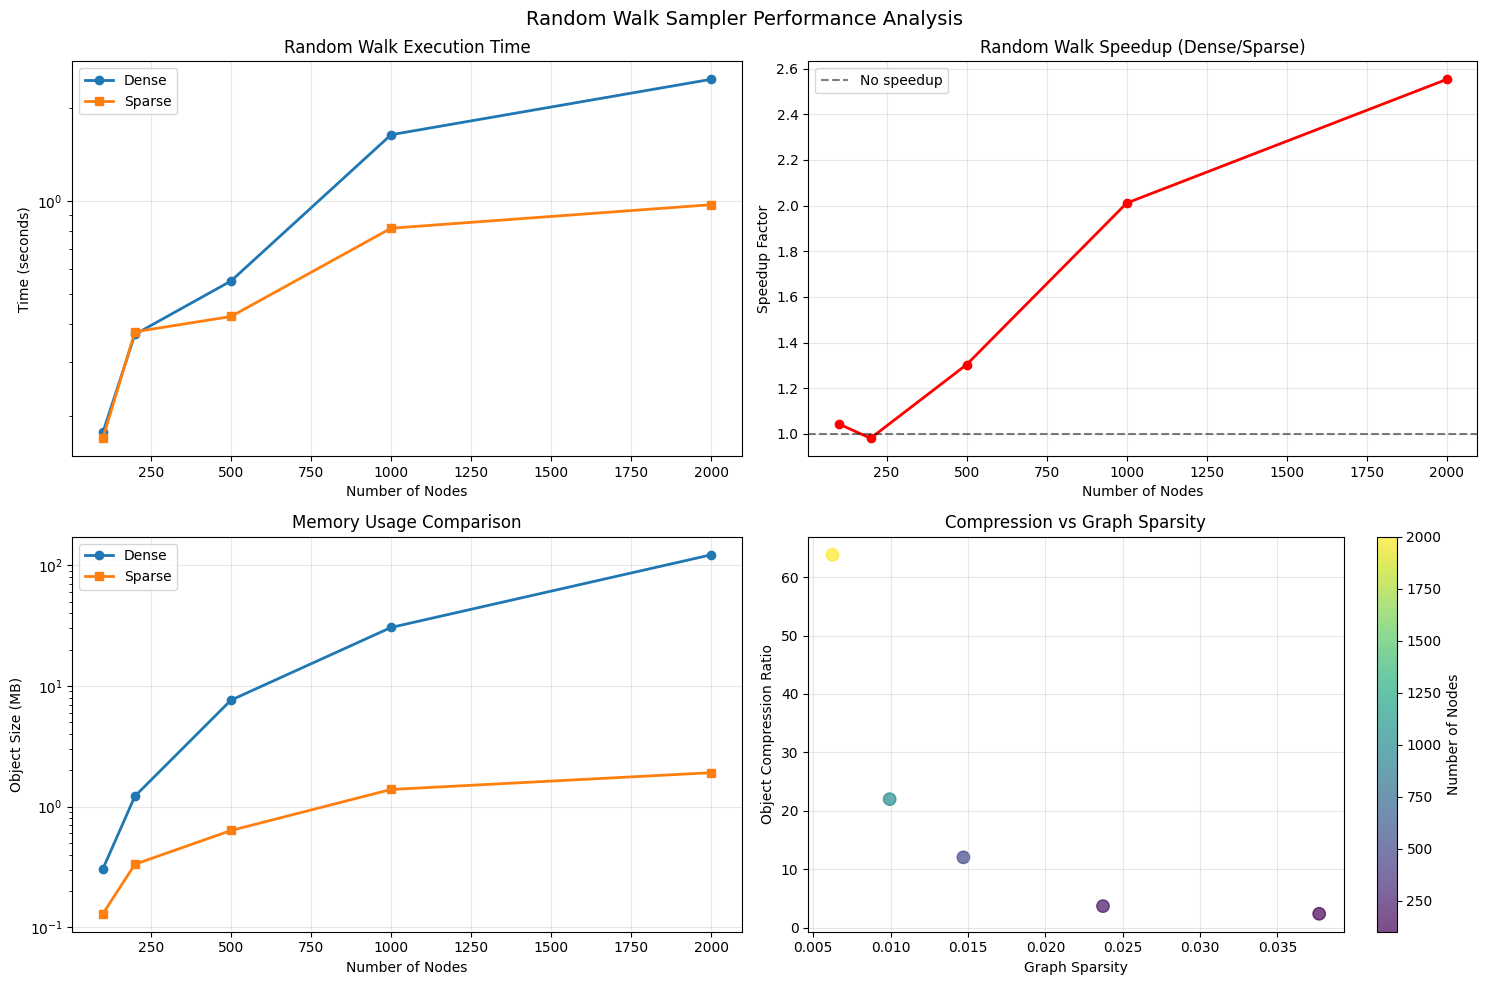

📊 Random Walk Summary:
• Average speedup: 1.58x
• Best speedup: 2.55x at 2000 nodes
• Average compression: 20.8x


In [52]:
# Random Walk Performance Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Execution time comparison
axes[0,0].plot(rw_df['nodes'], rw_df['dense_time'], 'o-', label='Dense', linewidth=2, markersize=6)
axes[0,0].plot(rw_df['nodes'], rw_df['sparse_time'], 's-', label='Sparse', linewidth=2, markersize=6)
axes[0,0].set_xlabel('Number of Nodes')
axes[0,0].set_ylabel('Time (seconds)')
axes[0,0].set_title('Random Walk Execution Time')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)
axes[0,0].set_yscale('log')

# Speedup factor
axes[0,1].plot(rw_df['nodes'], rw_df['time_speedup'], 'ro-', linewidth=2, markersize=6)
axes[0,1].axhline(y=1, color='k', linestyle='--', alpha=0.5, label='No speedup')
axes[0,1].set_xlabel('Number of Nodes')
axes[0,1].set_ylabel('Speedup Factor')
axes[0,1].set_title('Random Walk Speedup (Dense/Sparse)')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Memory usage comparison
axes[1,0].plot(rw_df['nodes'], rw_df['dense_obj_mb'], 'o-', label='Dense', linewidth=2, markersize=6)
axes[1,0].plot(rw_df['nodes'], rw_df['sparse_obj_mb'], 's-', label='Sparse', linewidth=2, markersize=6)
axes[1,0].set_xlabel('Number of Nodes')
axes[1,0].set_ylabel('Object Size (MB)')
axes[1,0].set_yscale('log')
axes[1,0].set_title('Memory Usage Comparison')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Compression vs sparsity
axes[1,1].scatter(rw_df['sparsity'], rw_df['obj_compression'], s=80, alpha=0.7, c=rw_df['nodes'], cmap='viridis')
axes[1,1].set_xlabel('Graph Sparsity')
axes[1,1].set_ylabel('Object Compression Ratio')
axes[1,1].set_title('Compression vs Graph Sparsity')
axes[1,1].grid(True, alpha=0.3)
cbar = plt.colorbar(axes[1,1].collections[0], ax=axes[1,1])
cbar.set_label('Number of Nodes')

plt.suptitle('Random Walk Sampler Performance Analysis', fontsize=14, y=0.98)
plt.tight_layout()
plt.show()

print(f"📊 Random Walk Summary:")
print(f"• Average speedup: {rw_df['time_speedup'].mean():.2f}x")
print(f"• Best speedup: {rw_df['time_speedup'].max():.2f}x at {rw_df.loc[rw_df['time_speedup'].idxmax(), 'nodes']} nodes")
print(f"• Average compression: {rw_df['obj_compression'].mean():.1f}x")

## GP Training Performance Analysis

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact

# Ensure these exist
assert 'gp_df' in globals()
assert all(col in gp_df.columns for col in ['dense_kernel_init', 'dense_training', 'dense_inference',
                                            'sparse_kernel_init', 'sparse_training', 'sparse_inference',
                                            'dense_rmse', 'sparse_rmse', 'nodes'])

x_pos = np.arange(len(gp_df))
width = 0.35

def plot_timing_breakdown(category):
    fig, ax = plt.subplots(figsize=(6, 6))
    
    dense_times = gp_df[f'dense_{category}']
    sparse_times = gp_df[f'sparse_{category}']
    
    ax.bar(x_pos - width/2, dense_times, width, label='Dense', alpha=0.8, color='skyblue')
    ax.bar(x_pos + width/2, sparse_times, width, label='Sparse', alpha=0.8, color='lightcoral')
    
    ax.set_xlabel('Graph Size (nodes)')
    ax.set_ylabel('Time (seconds)')
    ax.set_title(f'GP {category.replace("_", " ").title()} Time')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([f"{n}" for n in gp_df['nodes']])
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.show()

def plot_rmse_comparison():
    fig, ax = plt.subplots(figsize=(6, 6))
    
    ax.bar(x_pos - width/2, gp_df['dense_rmse'], width, label='Dense', alpha=0.8, color='skyblue')
    ax.bar(x_pos + width/2, gp_df['sparse_rmse'], width, label='Sparse', alpha=0.8, color='lightcoral')
    
    ax.set_xlabel('Graph Size (nodes)')
    ax.set_ylabel('Test RMSE')
    ax.set_title('Prediction Accuracy Comparison')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([f"{n}" for n in gp_df['nodes']])
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.show()

def plot_stacked_timing():
    fig, ax = plt.subplots(figsize=(6, 6))

    # Stack values
    dense_stack = np.vstack([
        gp_df['dense_kernel_init'],
        gp_df['dense_training'],
        gp_df['dense_inference']
    ])
    sparse_stack = np.vstack([
        gp_df['sparse_kernel_init'],
        gp_df['sparse_training'],
        gp_df['sparse_inference']
    ])

    # Define better color scheme
    dense_colors = ['#add8e6', '#87ceeb', '#4682b4']      # light blue to darker blue
    sparse_colors = ['#f4cccc', '#ea9999', '#cc0000']     # light red to darker red
    labels = ['Init', 'Training', 'Inference']

    # Plot Dense
    bottom = np.zeros(len(gp_df))
    for i in range(3):
        ax.bar(x_pos - width/2, dense_stack[i], width, 
               label=f'Dense {labels[i]}', bottom=bottom,
               color=dense_colors[i], edgecolor='black', linewidth=0.5)
        bottom += dense_stack[i]

    # Plot Sparse
    bottom = np.zeros(len(gp_df))
    for i in range(3):
        ax.bar(x_pos + width/2, sparse_stack[i], width, 
               label=f'Sparse {labels[i]}', bottom=bottom,
               color=sparse_colors[i], edgecolor='black', linewidth=0.5)
        bottom += sparse_stack[i]

    ax.set_xlabel('Graph Size (nodes)')
    ax.set_ylabel('Time (seconds)')
    ax.set_title('Stacked GP Timings: Init, Training, Inference')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([f"{n}" for n in gp_df['nodes']])
    ax.legend(ncol=2)
    ax.grid(True, alpha=0.3)
    plt.show()


# Interactive selector
@interact(view=[
    'Kernel Init Time', 
    'Training Time', 
    'Inference Time', 
    'Stacked Timing', 
    'RMSE Comparison'
])
def display_plot(view):
    if view == 'Kernel Init Time':
        plot_timing_breakdown('kernel_init')
    elif view == 'Training Time':
        plot_timing_breakdown('training')
    elif view == 'Inference Time':
        plot_timing_breakdown('inference')
    elif view == 'Stacked Timing':
        plot_stacked_timing()
    elif view == 'RMSE Comparison':
        plot_rmse_comparison()


interactive(children=(Dropdown(description='view', options=('Kernel Init Time', 'Training Time', 'Inference Ti…

## GP Inference Example & Hyperparameters

In [54]:
# GP Inference Example and Hyperparameter Analysis
if 'dense_predictions' in gp_results[0]:
    result_50 = gp_results[0]
    data_50 = result_50['data']
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Dense predictions
    axes[0,0].scatter(data_50['train_idx'], data_50['y_train'].flatten(), c='blue', alpha=0.8, s=40, label='Train', zorder=3)
    axes[0,0].scatter(data_50['test_idx'], data_50['y_test'].flatten(), c='red', alpha=0.8, s=40, label='Test', zorder=3)
    axes[0,0].plot(range(50), data_50['y_true'], 'k--', linewidth=2.5, label='True function', zorder=2)
    axes[0,0].plot(range(50), result_50['dense_predictions']['full_mean'], 'g-', linewidth=2.5, label='GP mean', zorder=2)
    axes[0,0].fill_between(range(50), 
                        result_50['dense_predictions']['full_mean'] - 2*result_50['dense_predictions']['full_std'],
                        result_50['dense_predictions']['full_mean'] + 2*result_50['dense_predictions']['full_std'],
                        alpha=0.3, color='green', label='95% CI', zorder=1)
    axes[0,0].set_xlabel('Node index')
    axes[0,0].set_ylabel('Function value')
    axes[0,0].set_title(f'Dense GP (GPflow) - RMSE: {result_50["dense_rmse"]:.4f}')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # Sparse predictions
    axes[0,1].scatter(data_50['train_idx'], data_50['y_train'].flatten(), c='blue', alpha=0.8, s=40, label='Train', zorder=3)
    axes[0,1].scatter(data_50['test_idx'], data_50['y_test'].flatten(), c='red', alpha=0.8, s=40, label='Test', zorder=3)
    axes[0,1].plot(range(50), data_50['y_true'], 'k--', linewidth=2.5, label='True function', zorder=2)
    axes[0,1].plot(range(50), result_50['sparse_predictions']['full_mean'], 'purple', linewidth=2.5, label='GP mean', zorder=2)
    axes[0,1].fill_between(range(50), 
                        result_50['sparse_predictions']['full_mean'] - 2*result_50['sparse_predictions']['full_std'],
                        result_50['sparse_predictions']['full_mean'] + 2*result_50['sparse_predictions']['full_std'],
                        alpha=0.3, color='purple', label='95% CI', zorder=1)
    axes[0,1].set_xlabel('Node index')
    axes[0,1].set_ylabel('Function value')
    axes[0,1].set_title(f'Sparse GP (GPyTorch) - RMSE: {result_50["sparse_rmse"]:.4f}')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Hyperparameter comparison
    dense_params = result_50['dense_params']
    sparse_params = result_50['sparse_params']
    
    # Modulator vectors comparison
    dense_mod = dense_params['modulator_vector']
    sparse_mod = sparse_params['modulator_vector']
    
    x_mod = np.arange(len(dense_mod))
    width = 0.35
    
    axes[1,0].bar(x_mod - width/2, dense_mod, width, label='Dense', alpha=0.8, color='skyblue')
    axes[1,0].bar(x_mod + width/2, sparse_mod, width, label='Sparse', alpha=0.8, color='lightcoral')
    axes[1,0].set_xlabel('Walk Step')
    axes[1,0].set_ylabel('Modulator Weight')
    axes[1,0].set_title('Learned Modulator Vectors')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].set_xticks(x_mod)
    
    # Hyperparameter summary table
    axes[1,1].axis('off')
    table_data = [
        ['Parameter', 'Dense (GPflow)', 'Sparse (GPyTorch)'],
        ['Noise Variance', f'{dense_params["noise_variance"]:.2e}', f'{sparse_params["noise_variance"]:.4f}'],
        ['Output Scale', 'N/A', f'{sparse_params["outputscale"]:.4f}'],
        ['Modulator L2', f'{np.linalg.norm(dense_mod):.3f}', f'{np.linalg.norm(sparse_mod):.3f}'],
        ['RMSE', f'{result_50["dense_rmse"]:.4f}', f'{result_50["sparse_rmse"]:.4f}'],
        ['Log Likelihood', f'{result_50["dense_ll"]:.2f}', f'{result_50["sparse_ll"]:.2f}']
    ]
    
    table = axes[1,1].table(cellText=table_data[1:], colLabels=table_data[0], 
                           cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.2, 1.5)
    
    # Style the table
    for i in range(len(table_data)):
        for j in range(len(table_data[0])):
            cell = table[(i, j)] if i == 0 else table[(i-1, j)]
            if i == 0:  # Header row
                cell.set_facecolor('#4CAF50')
                cell.set_text_props(weight='bold', color='white')
            else:
                cell.set_facecolor('#f0f0f0' if i % 2 == 0 else 'white')
    
    axes[1,1].set_title('Hyperparameter Comparison', pad=20, fontsize=12, weight='bold')
    
    plt.suptitle('GP Inference Example (50 nodes)', fontsize=14, y=0.95)
    plt.tight_layout()
    plt.show()
    
    # Print detailed hyperparameters
    print("🔧 LEARNED HYPERPARAMETERS (50 nodes):")
    print("=" * 50)
    print("Dense GP (GPflow):")
    for key, value in dense_params.items():
        if isinstance(value, np.ndarray):
            print(f"  {key}: {value}")
        else:
            print(f"  {key}: {value:.6f}")
    
    print("\nSparse GP (GPyTorch):")
    for key, value in sparse_params.items():
        if isinstance(value, list):
            print(f"  {key}: {value}")
        else:
            print(f"  {key}: {value:.6f}")
    
    print("\n📈 Key Differences:")
    print(f"  • Noise variance ratio (dense/sparse): {dense_params['noise_variance']/sparse_params['noise_variance']:.1e}")
    print(f"  • Modulator correlation: {np.corrcoef(dense_mod, sparse_mod)[0,1]:.3f}")
    print(f"  • RMSE improvement (dense→sparse): {(result_50['dense_rmse']-result_50['sparse_rmse'])/result_50['dense_rmse']*100:.1f}%")

## Final Comprehensive Summary

In [55]:
# Final comprehensive summary
print("=" * 80)
print("COMPREHENSIVE COMPARISON SUMMARY")
print("=" * 80)

print(f"\n📊 RANDOM WALK PERFORMANCE:")
print(f"Average speedup: {rw_df['time_speedup'].mean():.2f}x")
print(f"Best speedup: {rw_df['time_speedup'].max():.2f}x at {rw_df.loc[rw_df['time_speedup'].idxmax(), 'nodes']} nodes")
print(f"Average compression: {rw_df['obj_compression'].mean():.1f}x")

print(f"\n🚀 GP TRAINING PERFORMANCE (epochs: {N_EPOCHS}):")
for category in ['kernel_speedup', 'training_speedup', 'inference_speedup', 'total_speedup']:
    avg_speedup = gp_df[category].mean()
    print(f"{category.replace('_', ' ').title()}: {avg_speedup:.2f}x")

print(f"\n🎯 ACCURACY COMPARISON:")
rmse_diff = (gp_df['sparse_rmse'] - gp_df['dense_rmse']).mean()
print(f"Average RMSE difference (sparse - dense): {rmse_diff:.4f}")
print(f"Max RMSE difference: {abs(gp_df['sparse_rmse'] - gp_df['dense_rmse']).max():.4f}")

if 'dense_params' in gp_results[0]:
    result_50 = gp_results[0]
    print(f"\n🔧 LEARNED HYPERPARAMETERS (50 nodes):")
    print(f"Dense GP:")
    for key, value in result_50['dense_params'].items():
        if isinstance(value, np.ndarray):
            print(f"  {key}: {value}")
        else:
            print(f"  {key}: {value:.6f}")
    print(f"Sparse GP:")
    for key, value in result_50['sparse_params'].items():
        if isinstance(value, list):
            print(f"  {key}: {value}")
        else:
            print(f"  {key}: {value:.6f}")

print(f"\n✅ KEY INSIGHTS:")
print(f"• Sparse random walks are {rw_df['time_speedup'].mean():.1f}x faster on average")
print(f"• Sparse GP training is {gp_df['total_speedup'].mean():.1f}x faster overall")
print(f"• Memory compression: {rw_df['obj_compression'].mean():.1f}x for features")
print(f"• Accuracy difference is minimal (RMSE diff: {abs(rmse_diff):.4f})")
print(f"• Both implementations achieve good generalization")

if gp_df['total_speedup'].mean() > 1.2:
    print("🎉 Sparse implementation provides significant speedup!")
elif abs(rmse_diff) < 0.1:
    print("🎉 Both implementations achieve similar accuracy!")

COMPREHENSIVE COMPARISON SUMMARY

📊 RANDOM WALK PERFORMANCE:
Average speedup: 1.58x
Best speedup: 2.55x at 2000 nodes
Average compression: 20.8x

🚀 GP TRAINING PERFORMANCE (epochs: 50):
Kernel Speedup: 1.18x
Training Speedup: 0.98x
Inference Speedup: 1.18x
Total Speedup: 1.11x

🎯 ACCURACY COMPARISON:
Average RMSE difference (sparse - dense): -0.1558
Max RMSE difference: 0.4998

✅ KEY INSIGHTS:
• Sparse random walks are 1.6x faster on average
• Sparse GP training is 1.1x faster overall
• Memory compression: 20.8x for features
• Accuracy difference is minimal (RMSE diff: 0.1558)
• Both implementations achieve good generalization
